<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-07/W-GAN-GP-TF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 38kB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 3.2MB 51.5MB/s 
     |████████████████████████████████| 491kB 53.9MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [3]:
pip install keras==2.2.5

     |████████████████████████████████| 337kB 18.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
import tensorflow as tf
import keras
print (tf.__version__)

1.14.0


Using TensorFlow backend.


In [3]:
print (keras.__version__)

2.3.0


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


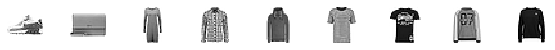

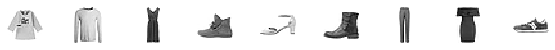

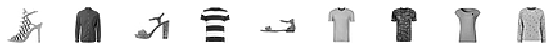

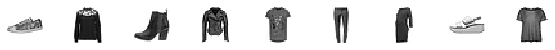

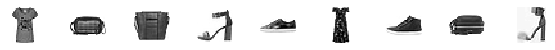

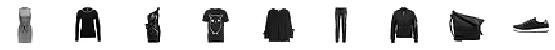

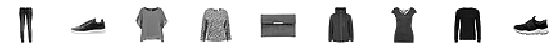

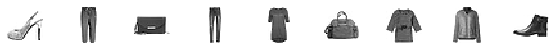

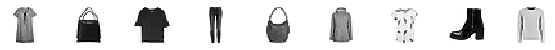

In [4]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(10, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

In [5]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [7]:
def make_generator(random_input): 
    x = keras.layers.Dense(7*7*128)(random_input)
    x = keras.layers.Reshape((7, 7, 128))(x)

    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4), padding='same')(x)
    generated_image = keras.layers.Activation('tanh')(x)

    generator_network = keras.models.Model(inputs=random_input, outputs=generated_image)
    print (generator_network.summary())
    return generator_network

# Critic

In [8]:
def make_critic(): 
    image_input = keras.layers.Input(shape=(28, 28, 1))

    x = keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same')(image_input)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.Flatten()(x)

    c_out = keras.layers.Dense(1)(x)

    critic_network = keras.models.Model(inputs=image_input, outputs=c_out)

    print (critic_network.summary())
    return critic_network

# Compiling Classisfiers

In [9]:
# custom loss function
def wasserstein_loss(y_true, y_pred):
    return keras.backend.mean(y_true * y_pred)

In [10]:
# This cell code is taken from: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py
import keras
from functools import partial
import keras.backend as K
from keras.layers.merge import _Merge

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    """
    Computes gradient penalty based on prediction and weighted real / fake samples
    """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

In [18]:
def make_wgan_gp():
    real_img = keras.Input(shape=(28, 28, 1))
    random_input = keras.layers.Input(shape=(100,))
    
    generator_network = make_generator(random_input)
    critic_network = make_critic()
    
    fake_img = generator_network(random_input)

    interpolated_img = RandomWeightedAverage()([real_img, fake_img])
    c_out_interpolated = critic_network(interpolated_img)

    partial_gp_loss = partial(gradient_penalty_loss,
                              averaged_samples=interpolated_img)
    partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

    fake = critic_network(fake_img)
    real = critic_network(real_img)

    critic_model = keras.models.Model(inputs=[real_img, random_input], outputs=[real, fake, c_out_interpolated])
    
    #Defining Combined Model
    critic_network.trainable=False
    generator_network.trainable=True

    noise_input = keras.layers.Input(shape=(100,))
    g_output = generator_network(noise_input)
    c_output = critic_network(g_output)

    wgan_gp_model = keras.models.Model(inputs = noise_input, outputs = c_output)
    print (wgan_gp_model.summary())
    
    # compiling models
    optimizer = keras.optimizers.RMSprop(lr=0.00005)

    critic_model.compile(loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss], \
                         optimizer=optimizer, metrics=['accuracy'], loss_weights=[1,1,10])

    wgan_gp_model.compile(loss=wasserstein_loss, optimizer=optimizer)
    
    return critic_model, wgan_gp_model, generator_network

In [19]:
critic_model, wgan_gp_model, generator_network = make_wgan_gp()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 64)        1311

# Define Data Generators

In [21]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batches

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batches)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(9, 6))
        random_noise_batches = get_random_noise(10, noise_size) 
        fake_samples = generator_network.predict_on_batch(random_noise_batches)
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
            plt.axis('off')
        plt.show()
    return

# Training GAN

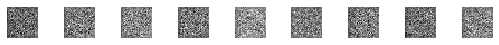

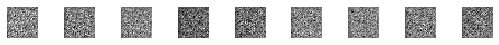

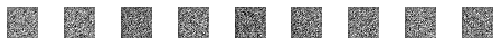

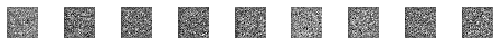

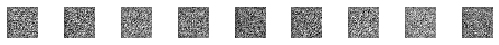

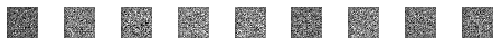

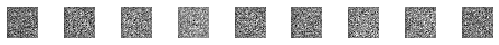

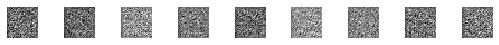

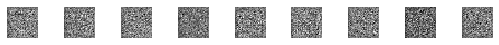

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch:0, Step:0, C-Loss:34.875 G-Loss:-0.353
Epoch:0, Step:50, C-Loss:15.471 G-Loss:-0.329
Epoch:0, Step:100, C-Loss:17.495 G-Loss:-0.606
Epoch:0, Step:150, C-Loss:12.978 G-Loss:-0.333
Epoch:0, Step:200, C-Loss:12.893 G-Loss:-0.211
Epoch:0, Step:250, C-Loss:11.196 G-Loss:0.081
Epoch:0, Step:300, C-Loss:12.492 G-Loss:0.232
Epoch:0, Step:350, C-Loss:10.682 G-Loss:0.127
Epoch:0, Step:400, C-Loss:9.273 G-Loss:-0.042
Epoch:0, Step:450, C-Loss:12.234 G-Loss:0.080


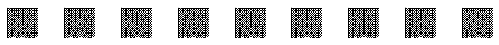

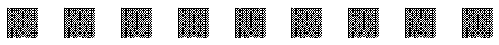

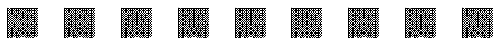

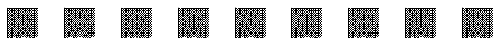

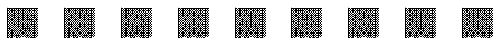

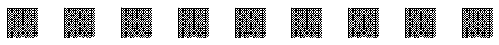

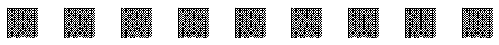

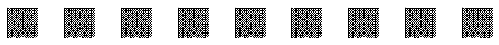

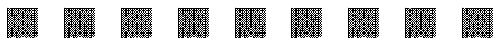

Epoch:1, Step:0, C-Loss:9.522 G-Loss:0.123
Epoch:1, Step:50, C-Loss:12.648 G-Loss:0.092
Epoch:1, Step:100, C-Loss:16.530 G-Loss:0.394
Epoch:1, Step:150, C-Loss:12.441 G-Loss:0.260
Epoch:1, Step:200, C-Loss:2.517 G-Loss:0.515
Epoch:1, Step:250, C-Loss:3.038 G-Loss:0.582
Epoch:1, Step:300, C-Loss:1.739 G-Loss:0.978
Epoch:1, Step:350, C-Loss:2.362 G-Loss:1.202
Epoch:1, Step:400, C-Loss:-0.248 G-Loss:1.494
Epoch:1, Step:450, C-Loss:0.378 G-Loss:1.803


In [ ]:
epochs = 500
batch_size = 32
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%1 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        # With Number of Critics=5
        for _ in range(5):
            random_noise_batch = get_random_noise(batch_size, noise_size)
            real_samples = get_real_samples(batch_size=batch_size)

            fake_y = np.ones((batch_size, 1))
            real_y = -np.ones((batch_size, 1))
            dummy = np.zeros((batch_size, 1))

            # Updating Critic weights
            #critic_network.trainable=True
            loss_c = critic_model.train_on_batch([real_samples,random_noise_batch], [real_y, fake_y, dummy])
        
        noise_batch = get_random_noise(batch_size, noise_size)
        wgan_input = noise_batch
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        wgan_output = -np.ones((batch_size, 1))
        
        # Updating Generator weights
        #critic_network.trainable=False
        loss_g = wgan_gp_model.train_on_batch(wgan_input, wgan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, C-Loss:%.3f G-Loss:%.3f"%(i,j,loss_c[0],loss_g))